<a href="https://colab.research.google.com/github/luispc1989/MachineLearning/blob/main/Assignment_4_train_mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
# Install and import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import random
import numpy as np
from torchsummary import summary

In [70]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [71]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [72]:
# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((8, 8)),
    transforms.ToTensor(),
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [73]:
# Define convolutional block with batch normalization
def conv(ic, oc, act=True):
    ks = 3
    layers = [
        nn.Conv2d(ic, oc, stride=2, kernel_size=ks, padding=ks//2),
        nn.BatchNorm2d(oc)
    ]
    if act:
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)

# Build the CNN model
simple_cnn = nn.Sequential(
    conv(1, 8),
    nn.Dropout2d(p=0.25),
    conv(8, 16),
    nn.Dropout2d(p=0.25),
    conv(16, 10, act=False),
    nn.Flatten()
)

In [74]:
# Example usage with a dummy input
xb = torch.randn(64, 1, 8, 8)
output = simple_cnn(xb)
print(output.shape)  # torch.Size([64, 10])

# Print model summary
simple_cnn.to(device)
summary(simple_cnn, input_size=(1, 8, 8), device=str(device))

torch.Size([64, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 8, 4, 4]              80
       BatchNorm2d-2              [-1, 8, 4, 4]              16
              ReLU-3              [-1, 8, 4, 4]               0
         Dropout2d-4              [-1, 8, 4, 4]               0
            Conv2d-5             [-1, 16, 2, 2]           1,168
       BatchNorm2d-6             [-1, 16, 2, 2]              32
              ReLU-7             [-1, 16, 2, 2]               0
         Dropout2d-8             [-1, 16, 2, 2]               0
            Conv2d-9             [-1, 10, 1, 1]           1,450
      BatchNorm2d-10             [-1, 10, 1, 1]              20
          Flatten-11                   [-1, 10]               0
Total params: 2,766
Trainable params: 2,766
Non-trainable params: 0
----------------------------------------------------------------
Input size (M

In [75]:
# Function to compute accuracy
def compute_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    return correct / len(labels)

In [76]:
# Training loop with validation and saving weights
num_epochs = 6
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(simple_cnn.parameters(), lr=0.001)
history = {'epoch': [], 'train_accuracy': [], 'val_accuracy': []}

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}; Time: {round(time.time())}")
    simple_cnn.train()
    train_accs = []
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = simple_cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_accs.append(compute_accuracy(outputs, labels))

    avg_train_acc = sum(train_accs) / len(train_accs)
    history['epoch'].append(epoch + 1)
    history['train_accuracy'].append(avg_train_acc)
    print(f"Train Accuracy: {avg_train_acc:.4f}")

    # Validation
    simple_cnn.eval()
    val_accs = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = simple_cnn(images)
            val_accs.append(compute_accuracy(outputs, labels))
    avg_val_acc = sum(val_accs) / len(val_accs)
    history['val_accuracy'].append(avg_val_acc)
    print(f"Validation Accuracy: {avg_val_acc:.4f}")

    # Save weights for each epoch
    torch.save(simple_cnn.state_dict(), f"cnn_epoch_{epoch+1}.pth")

Epoch 1/6; Time: 1749575376
Train Accuracy: 0.7133
Validation Accuracy: 0.9029
Epoch 2/6; Time: 1749575410
Train Accuracy: 0.8272
Validation Accuracy: 0.9255
Epoch 3/6; Time: 1749575439
Train Accuracy: 0.8460
Validation Accuracy: 0.9286
Epoch 4/6; Time: 1749575467
Train Accuracy: 0.8557
Validation Accuracy: 0.9365
Epoch 5/6; Time: 1749575495
Train Accuracy: 0.8630
Validation Accuracy: 0.9382
Epoch 6/6; Time: 1749575523
Train Accuracy: 0.8658
Validation Accuracy: 0.9400


In [77]:
# Final model save for deployment
final_model_path = "mnist_cnn_final.pth"
torch.save(simple_cnn.state_dict(), final_model_path)
print(f"Final model saved to: {final_model_path}")

Final model saved to: mnist_cnn_final.pth


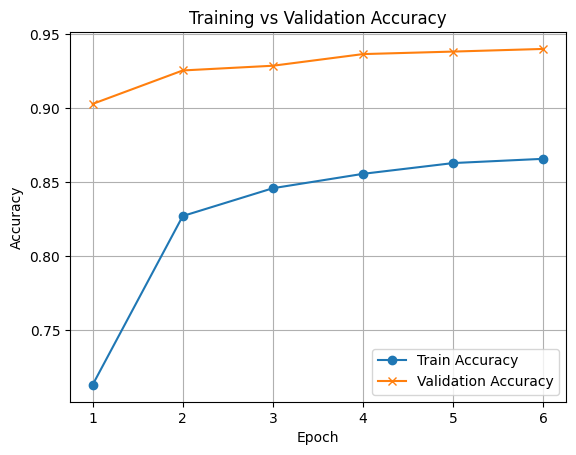

In [78]:
# Plot training and validation accuracy
plt.plot(history['epoch'], history['train_accuracy'], label='Train Accuracy', marker='o')
plt.plot(history['epoch'], history['val_accuracy'], label='Validation Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
